In [5]:
import artif_gen_methods as agm
import config
import helper_fxns as hf
import numpy as np
import importlib
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
importlib.reload(hf)
importlib.reload(config)
importlib.reload(agm)
C = config.Config()

In [72]:
n = 1500

agm.gen_imgs("cyst", C, n)
agm.gen_imgs("hcc", C, n)
agm.gen_imgs("hemangioma", C, n)
agm.gen_imgs("cholangio", C, n)
agm.gen_imgs("colorectal", C, n)
agm.gen_imgs("fnh", C, n)

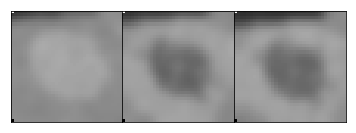

In [65]:
img = agm.gen_hccs(C, 30)[17]
img = agm.post_process_img(img, C)
hf.plot_section_auto(img, normalize=True)

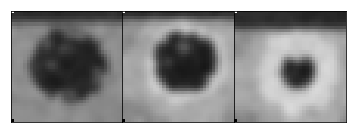

In [66]:
img = agm.gen_hemangiomas(C, 30)[12]
img = agm.post_process_img(img, C)
hf.plot_section_auto(img, normalize=True)

In [ ]:
cls = "fnh"
img = np.load(C.artif_dir + cls + "\\artificial_150.npy")
hf.plot_section_auto_scan(img, 0.3)